# Tulipa multi-year investment demonstration

- Adapted from Tulipa tutorial [multi-year investment](https://hackmd.io/CnhwFt1DQ_iT1LH_lQ7h0A)
> see in the `TulipaTUtorials/TulipaMultiYear.ipynb` for `TulipaTUtorials/Tulipa-multi-year-full`.

# Setup workflow environment

In [1]:
using Pkg; Pkg.activate(@__DIR__)

import TulipaIO as TIO
import TulipaEnergyModel as TEM
import TulipaClustering as TC
using DuckDB
using DataFrames
using Plots

# # For Win. system to fix the KaTex parse error in Jupyter Notebook
# Base.show(stdout, ::MIME"text/latex", df::DataFrame) = show(stdout, MIME("text/plain"), df)

  Activating project at `~/Projects/VintageDemo`


# Multi-year investment model cases

- Milestone years: 2030, 2040 and 2050.
- The system has 30GW initial wind capacity built in 2025, the model can choose to invest in wind in all three milestone years.
- unused tables: `flow-both.csv`, `flows-profiles.csv`

## 1: Without unit vintage

> Note: the `output_dir` must exist/(be created) beforehand 

### 1.1 Build and run the model instance

In [5]:
connection = DBInterface.connect(DuckDB.DB)
input_dir = "model-instance-Tulipa/inputs-no-vintage"
output_dir = joinpath(@__DIR__, "model-instance-Tulipa/outputs-no-vintage")

# Always build a new result directory
rm(output_dir, force=true, recursive=true) 
mkdir(output_dir);

# Create the connection and prepare input data
connection_no_vintage = DBInterface.connect(DuckDB.DB)
TIO.read_csv_folder(connection_no_vintage, input_dir)
TEM.populate_with_defaults!(connection_no_vintage)

# Run the model instance
multiyear_no_vintage = TEM.run_scenario(
    connection_no_vintage;
    model_parameters_file = joinpath(@__DIR__, input_dir, "model-parameters.toml"),
    output_folder = output_dir, 
    model_file_name = joinpath(output_dir, "model.lp"),
    show_log=false,
)

ErrorException: Invalid coefficient NaN on variable assets_investment[2050,wind].

In [18]:
filter(row -> row.asset=="wind", TIO.get_table(connection_no_vintage, "var_assets_investment"))

Row,id,asset,milestone_year,investment_integer,capacity,investment_limit
,Int64,String,Int32,Bool,Float64,Float64?
1,1,wind,2030,true,1.0,missing
2,2,wind,2040,true,1.0,missing
3,3,wind,2050,true,1.0,missing


In [14]:
# show all input/output tables
println(TIO.show_tables(connection_no_vintage).name)
TIO.show_tables(connection_no_vintage)

["asset", "asset_both", "asset_commission", "asset_milestone", "asset_time_resolution_over_clustered_year", "asset_time_resolution_rep_period", "assets_profiles", "assets_rep_periods_partitions", "assets_timeframe_partitions", "assets_timeframe_profiles", "cons_balance_consumer", "cons_balance_conversion", "cons_balance_hub", "cons_balance_storage_over_clustered_year", "cons_balance_storage_rep_period", "cons_capacity_incoming_simple_method", "cons_capacity_incoming_simple_method_investable_storage_with_binary", "cons_capacity_incoming_simple_method_non_investable_storage_with_binary", "cons_capacity_outgoing_compact_method", "cons_capacity_outgoing_semi_compact_method", "cons_capacity_outgoing_simple_method", "cons_capacity_outgoing_simple_method_investable_storage_with_binary", "cons_capacity_outgoing_simple_method_non_investable_storage_with_binary", "cons_dc_power_flow", "cons_flows_relationships", "cons_group_max_investment_limit", "cons_group_min_investment_limit", "cons_limit_de

Row,name
,String
1,asset
2,asset_both
3,asset_commission
4,asset_milestone
5,asset_time_resolution_over_clustered_year
6,asset_time_resolution_rep_period
7,assets_profiles
8,assets_rep_periods_partitions
9,assets_timeframe_partitions


### 1.2 Key results

#### Capacity

Check the "initial capacity" 

- in this case, we will not be able to differentiate units built in other years (than milestone years), 
- they will simply be considered the same as the units built in the milestone year, 
- which means that we will not use the 2020 profile.

In [4]:
# initial capacity
filter(row -> row.asset=="wind", TIO.get_table(connection_no_vintage, "asset_both"))

Row,asset,milestone_year,commission_year,decommissionable,initial_units,initial_storage_units
,String,Int32,Int32,Bool,Float64,Float64
1,wind,2030,2030,false,20.0,0.0
2,wind,2050,2050,false,20.0,0.0


In [4]:
# invested capacity
filter(row -> row.asset=="wind", TIO.get_table(connection_no_vintage, "var_assets_investment"))

UndefVarError: UndefVarError: `connection_no_vintage` not defined

#### Supply production

In [6]:
println(
    "wind prodution: ",
    filter(
        row -> occursin("wind", row.from_asset) && row.to_asset == "demand", 
        TIO.get_table(connection_no_vintage, "var_flow")
    ).solution |> sum
)
println(
    "unserved energy: ", 
    filter(row -> row.from_asset == "ens" && row.to_asset == "demand", 
        TIO.get_table(connection_no_vintage, "var_flow")
    ).solution |> sum
)

wind prodution: 150110.28244437
unserved energy: 

41617.269057375


#### Objective: total system cost

In [7]:
println("Objective value: $(multiyear_no_vintage.objective_value)")

Objective value: 4.755307957083756e6


## 2: Explicit unit vintage

- Difference from case 1: `asset.csv`, `asset-milestone.csv`, `asset-commission.csv`, `asset-both`, `assets-profiles.csv`, `flow*.csv`
- In any milestone year, only the tech. vintage of the same year is available for investment (explicitly regulated by setting the `investable` parameter in `asset-milestone.csv`)
- Resulted investment in 2050 differ significantly from the no vintage case because the wind of 2020 vintage (`wind20`) uses the default availability of `1.0` for milestone year 2050 due to the lack of availability value is given for 2050 for this vintage (`availability-wind2020` records in `profiles-rep-periods.csv`, which is assigned to `wind20` in `assets-profiles.csv`)

### 2.1 Build and run the model instance

In [8]:
# Define and build the input output directories
input_dir = "model-instance-Tulipa/inputs-vintage-standard"
output_dir = joinpath(@__DIR__, "model-instance-Tulipa/outputs-vintage-standard")

# Always build a new result directory
rm(output_dir, force=true, recursive=true) 
mkdir(output_dir);

# Create the connection and prepare input data
connection_vintage_standard = DBInterface.connect(DuckDB.DB)
TIO.read_csv_folder(connection_vintage_standard, input_dir)
TEM.populate_with_defaults!(connection_vintage_standard)

# Run the model instance
multiyear_vintage_standard = TEM.run_scenario(
    connection_vintage_standard;
    model_parameters_file = joinpath(@__DIR__, input_dir, "model-parameters-example.toml"),
    output_folder = output_dir, 
    model_file_name = joinpath(output_dir, "model.lp"),
    show_log=false,
)

EnergyProblem:
  - Model created!
    - Number of variables: 578
    - Number of constraints for variable bounds: 578
    - Number of structural constraints: 720
  - Model solved!
    - Termination status: OPTIMAL
    - Objective value: 4.689921442937199e6


### 2.2 Key results

#### Capacity

In [9]:
# initial capacity of the wind20
filter(row -> row.asset=="wind20", TIO.get_table(connection_vintage_standard, "asset_both"))

Row,asset,milestone_year,commission_year,decommissionable,initial_units,initial_storage_units
,String,Int32,Int32,Bool,Float64,Float64
1,wind20,2030,2030,false,20.0,0.0
2,wind20,2050,2050,false,20.0,0.0


In [10]:
# invested capacity of the wind30 and wind50
filter(row -> (row.asset=="wind30" || row.asset=="wind50"), TIO.get_table(connection_vintage_standard, "var_assets_investment"))

Row,id,asset,milestone_year,investment_integer,capacity,investment_limit,solution
,Int64,String,Int32,Bool,Float64,Float64?,Float64
1,1,wind30,2030,true,50.0,missing,38.0
2,2,wind50,2050,true,50.0,missing,11.0


#### Supply production

In [11]:
println(
    "wind prodution: ",
    filter(
        row -> occursin("wind", row.from_asset) && row.to_asset == "demand", 
        TIO.get_table(connection_vintage_standard, "var_flow")
    ).solution |> sum
)
println(
    "unserved energy: ", 
    filter(row -> row.from_asset == "ens" && row.to_asset == "demand", 
        TIO.get_table(connection_vintage_standard, "var_flow")
    ).solution |> sum
)

wind prodution: 166365.23056946314
unserved energy: 25362.320932281822


#### Objective: total system cost

In [12]:
println("Objective value: $(multiyear_vintage_standard.objective_value)")

Objective value: 4.689921442937199e6


## 3: Compact unit vintage

- Difference from case 1: `asset.csv` (only `investment_method`), `asset-commission.csv`, `asset-both`
- In any milestone year, only the tech. vintage of the same year is available for investment (assumed with setting `investment_method=compact`)
- Resulted investment in 2050 differ significantly from the no vintage case because the wind of 2020 vintage (wind commissioned in 2020, defined in `asset-commission.csv`) uses the default availability of `1.0` over the milestone year 2050 due to the lack of availability value is given for 2050 for this vintage (`availability-wind2020` records in `profiles-rep-periods.csv`, which is assigned to the wind commissioned in 2020 in `assets-profiles.csv`)

### 3.1 Build and run the model instance

In [13]:
# Define and build the input output directories
input_dir = "model-instance-Tulipa/inputs-vintage-compact"
output_dir = joinpath(@__DIR__, "model-instance-Tulipa/outputs-vintage-compact")

# Always build a new result directory
rm(output_dir, force=true, recursive=true) 
mkdir(output_dir);

# Create the connection and prepare input data
connection_vintage_compact = DBInterface.connect(DuckDB.DB)
TIO.read_csv_folder(connection_vintage_compact, input_dir)
TEM.populate_with_defaults!(connection_vintage_compact)

# Run the model instance
multiyear_vintage_compact = TEM.run_scenario(
    connection_vintage_compact;
    model_parameters_file = joinpath(@__DIR__, input_dir, "model-parameters-example.toml"),
    output_folder = output_dir, 
    model_file_name = joinpath(output_dir, "model.lp"),
    show_log=false,
)

EnergyProblem:
  - Model created!
    - Number of variables: 290
    - Number of constraints for variable bounds: 290
    - Number of structural constraints: 432
  - Model solved!
    - Termination status: OPTIMAL
    - Objective value: 4.6899239376978995e6


### 3.2 Key results

#### Capacity

- Units built in different years are explicitly listed, 
- meaning that their corresponding profiles are also considered.

In [14]:
# initial capacity of the wind commissioned in year 2020
filter(TIO.get_table(connection_vintage_compact, "asset_both")) do row
    # row.asset=="wind" && (row.milestone_year == 2030 || row.milestone_year == 2050)
    row.asset=="wind" && row.commission_year == 2020
end

Row,asset,milestone_year,commission_year,decommissionable,initial_units,initial_storage_units
,String,Int32,Int32,Bool,Float64,Float64
1,wind,2030,2020,false,20.0,0.0
2,wind,2050,2020,false,20.0,0.0


In [15]:
# invested capacity of the wind commissioned in the milestone year
filter(row -> row.asset=="wind", TIO.get_table(connection_vintage_compact, "var_assets_investment"))

Row,id,asset,milestone_year,investment_integer,capacity,investment_limit,solution
,Int64,String,Int32,Bool,Float64,Float64?,Float64
1,1,wind,2030,true,50.0,missing,38.0
2,2,wind,2050,true,50.0,missing,11.0


#### Supply production

In [16]:
println(
    "wind prodution: ",
    filter(
        row -> occursin("wind", row.from_asset) && row.to_asset == "demand", 
        TIO.get_table(connection_vintage_compact, "var_flow")
    ).solution |> sum
)
println(
    "unserved energy: ", 
    filter(row -> row.from_asset == "ens" && row.to_asset == "demand", 
        TIO.get_table(connection_vintage_compact, "var_flow")
    ).solution |> sum
)

wind prodution: 166364.76715482902
unserved energy: 25362.784346915978


#### Objective: total system cost

In [17]:
println("Objective value: $(multiyear_vintage_compact.objective_value)")

Objective value: 4.6899239376978995e6


# Testing ...

In [22]:
using CSV
# show all input/output tables
# println(TIO.show_tables(connection_standard).name)
CSV.write(joinpath(output_dir,"model_info.csv"), TIO.show_tables(connection_standard))

"/cluster/home/jiahuang/Projects/VintageDemo/model-instance-Tulipa/outputs-vintage-compact/model_info.csv"

In [19]:
filter(
    row -> occursin("demand", row.profile_name) && row.year == 2050,
    TIO.get_table(connection_standard, "profiles_rep_periods")
)

Row,profile_name,year,rep_period,timestep,value
,String,Int32,Int32,Int32,Float64
1,demand-demand,2050,1,1,0.852018
2,demand-demand,2050,1,2,0.780269
3,demand-demand,2050,1,3,0.730045
4,demand-demand,2050,1,4,0.698655
5,demand-demand,2050,1,5,0.679821
6,demand-demand,2050,1,6,0.673543
7,demand-demand,2050,1,7,0.698655
8,demand-demand,2050,1,8,0.747982
9,demand-demand,2050,1,9,0.808969


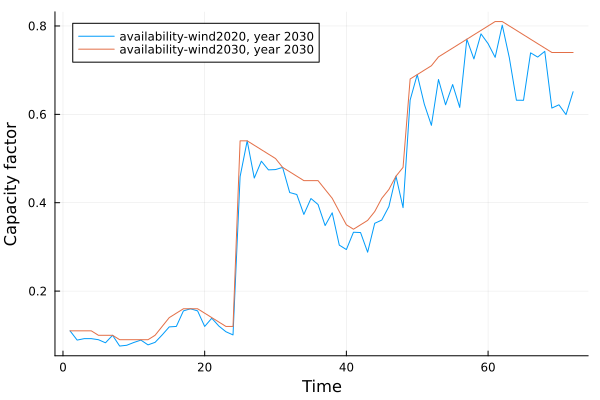

In [20]:
function plot_input_profiles(conn::DuckDB.DB, ::Val{:wind}, year::Int)
    plot()
    profiles = filter(
        row -> occursin(String(:wind), row.profile_name) && row.year == year,
        TIO.get_table(conn, "profiles_rep_periods")
    )

    for pname in unique(profiles.profile_name)
        subdf = profiles[profiles.profile_name .== pname, :]
        plot!(subdf.value, label="$(pname), year $year")
    end
    xlabel!("Time")
    ylabel!("Capacity factor")
end

plot_input_profiles(connection_standard, Val(:wind), 2030)

In [21]:
@show fieldnames(TEM.EnergyProblem)
# @show dump(TEM.EnergyProblem)
# var_flow = multiyear_vintage_compact.variables[:flow]
# fieldnames(typeof(var_flow))
# typeof(var_flow.indices)
# var_flow.indices.tbl[:id]
multiyear_no_vintage.expressions[:available_asset_units_simple_method]
TIO.show_tables(connection_vintage_compact)


fieldnames(TEM.EnergyProblem) = (:db_connection, :variables, :expressions, :constraints, :profiles, :model_parameters, :model, :solved, :objective_value, :termination_status)


Row,name
,String
1,asset
2,asset_both
3,asset_commission
4,asset_milestone
5,asset_time_resolution_over_clustered_year
6,asset_time_resolution_rep_period
7,assets_profiles
8,assets_rep_periods_partitions
9,assets_timeframe_partitions
